# Introduction

Welcome to Optiver competition! In this competition, we have to predict the closing price of hundreds Nasdaq-listed stocks based on the closing auction and order book of the stock. This is a time-series competition, and it seems that most of the test set will only be used after the submission period ends. Metrics used in this competition is Mean Absolute Error or MAE.

This is the first time I'm doing this kind of competition, so I appreciate any feedbacks. Before reading this notebook though, I recommend you to read these two first:
- https://www.kaggle.com/code/tomforbes/optiver-trading-at-the-close-introduction
- https://www.kaggle.com/code/sohier/optiver-2023-basic-submission-demo

In [1]:
#!python3.11 -m pip install seaborn lightgbm plotly_express nbformat catboost

# Loading Libraries and Datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import gc
import plotly_express as px

from sklearn import set_config
from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor


sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None

In [3]:
# train = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
train = pd.read_csv("train.csv")

gc.collect()

246

# Preparation

This is where we start preparing everything if we want to start building machine learning models. We will use Time Series Split for our cross validation process. We will also drop any rows where the missing target values are located.

In [4]:
seed = 42
tss = TimeSeriesSplit(10)

os.environ['PYTHONHASHSEED'] = '42'
tf.keras.utils.set_random_seed(seed)

# Cross-Validation

Honestly, there is only one usable non-neural network model I can think of for this data: LightGBM. First, there are a lot of missing values in the dataset, so we either have to impute them all, or just use model that can take care of it implicitly, which are XGBoost, LightGBM, and CatBoost. Second, the competition uses MAE as metric, and XGBoost's MAE loss function isn't good from my experience. Last, due to the size of the dataset, we want to use GPU to increase the speed, and guess what, CatBoost's MAE loss function can't be optimized with GPU. Therefore, LightGBM is the only one that can satisfy all our needs above.

Again, we are restricting ourselves to not use neural network for this notebook. We have to build one if we want to be competitive.

In [ ]:
def cross_val_score(estimatorConstructor, cv = tss, label = ''):
    
    X = train[~train.target.isna()]
    y = X.pop('target')
    
    #initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X)))
    #train_predictions = np.zeros((len(sample)))
    train_scores, val_scores = [], []
    
    #training model, predicting prognosis probability, and evaluating metrics   
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
        model = estimatorConstructor()
        
        #define train set
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        
        #define validation set
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        
        #train model
        model.fit(X_train, y_train)
        
        #make predictions
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
                  
        val_predictions[val_idx] += val_preds
        
        #evaluate model for a fold
        train_score = mean_absolute_error(y_train, train_preds)
        val_score = mean_absolute_error(y_val, val_preds)
        
        #append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)
    
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    
    return val_scores, val_predictions

In [6]:
#_ = cross_val_score(TestModel,label = 'SuperModel')

In [256]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
if "row_id" in train.columns:
    train.drop(["row_id"],axis=1,inplace=True)
if "time_id" in train.columns:
    train.drop(["time_id"],axis=1,inplace=True)
X = train[~train.target.isna()]
X = X.fillna(0)
y = X.pop('target')

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X = np.random.normal(0,1,(100000,2))
y= pd.DataFrame(X[:,0]/(X[:,0]+X[:,1]))

y_mean = y.mean()
y_factor = y.abs().max()
y=(y-y.mean())/y_factor




X_train, X_val, y_train, y_val = train_test_split(X[::1], y[::1], test_size=0.33, random_state=28)

In [257]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(2),
        tf.keras.layers.Dense(50, activation='tanh'),
        tf.keras.layers.Dropout(0.3),   
        tf.keras.layers.Dense(30,activation="tanh"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(20,activation="tanh"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10,activation="tanh"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(5,activation="tanh"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1,activation="tanh")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
              loss=tf.keras.losses.MeanSquaredError())
    return model
model = create_model()

In [218]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 50)                750       
                                                                 
 dropout_46 (Dropout)        (None, 50)                0         
                                                                 
 dense_74 (Dense)            (None, 30)                1530      
                                                                 
 dropout_47 (Dropout)        (None, 30)                0         
                                                                 
 dense_75 (Dense)            (None, 20)                620       
                                                                 
 dropout_48 (Dropout)        (None, 20)                0         
                                                                 
 dense_76 (Dense)            (None, 10)              

In [258]:
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100, batch_size=int(len(X_train)/4)*0+32*0+4096*1)

Epoch 1/100
17/17 [==============================] - 1s 22ms/step - loss: 0.0876 - val_loss: 9.8075e-05
Epoch 2/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0041 - val_loss: 6.4259e-05
Epoch 3/100
17/17 [==============================] - 0s 9ms/step - loss: 8.1137e-04 - val_loss: 3.9380e-05
Epoch 4/100
17/17 [==============================] - 0s 9ms/step - loss: 3.7425e-04 - val_loss: 3.8771e-05
Epoch 5/100
17/17 [==============================] - 0s 9ms/step - loss: 2.5796e-04 - val_loss: 3.8949e-05
Epoch 6/100
17/17 [==============================] - 0s 11ms/step - loss: 1.9811e-04 - val_loss: 3.8782e-05
Epoch 7/100
17/17 [==============================] - 0s 13ms/step - loss: 1.6182e-04 - val_loss: 3.8830e-05
Epoch 8/100
17/17 [==============================] - 0s 9ms/step - loss: 1.3253e-04 - val_loss: 3.8707e-05
Epoch 9/100
17/17 [==============================] - 0s 9ms/step - loss: 1.1506e-04 - val_loss: 3.8846e-05
Epoch 10/100
17/17 [======================

In [268]:
y_val

,0
6710,0.000049
10495,-0.000011
6252,0.000021
42682,0.000016
84557,-0.000007
...,...
3062,0.000019
78502,0.000003
92683,0.000050
88009,0.000005


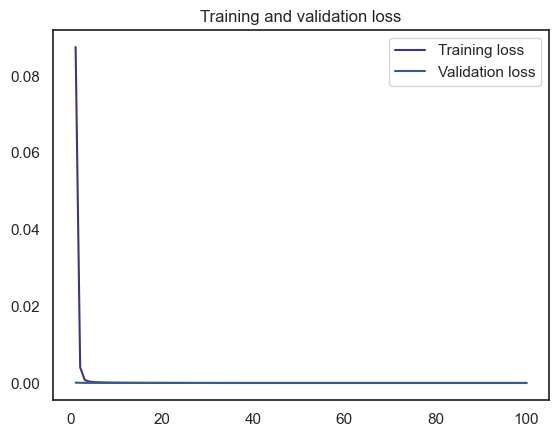

In [259]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [53]:
model = tf.keras.models.load_model('./model.keras')

In [231]:
y_pred = model.predict(X_val[0:10000])

313/313 [==============================] - 0s 714us/step


In [232]:
px.histogram(y_pred.reshape(-1)-y_val[0:10000])

In [ ]:
px.histogram(y_val)

In [224]:
y_pred[0:1000].std()/y_val[0:1000].std()

0.08257175414270634

In [228]:
(y_pred.reshape(-1)-y_val[0:10000]).abs().mean()*y_factor

6.673938303610853

0.021206504571538987